In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
class GroundingDino:
    def __init__(self,device = "cpu",class_list = ["apple","banana","orange"]):
        self.model_id = "IDEA-Research/grounding-dino-base"
        self.device = device
        self.processor = AutoProcessor.from_pretrained(self.model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(self.model_id).to(self.device)
        self.set_class_prompt(class_list)
        
    def set_class_prompt(self,set_class):
        self.set_class = set_class
        self.class_prompt = ". ".join(["a " + fruit for fruit in set_class]) + "."
        
    def __call__(self,image):
        inputs = self.processor(images=image, text=self.class_prompt, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        results = self.processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.4,
            text_threshold=0.3,
            target_sizes=[image.size[::-1]]
        )
        return results
    
    @staticmethod
    def visualize(image,results):
        fig, ax = plt.subplots()
        ax.imshow(image)
        for box in results[0]['boxes'].detach().cpu().numpy():
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()
    

In [3]:
model = GroundingDino(class_list = ["drum","guitar","piano"])

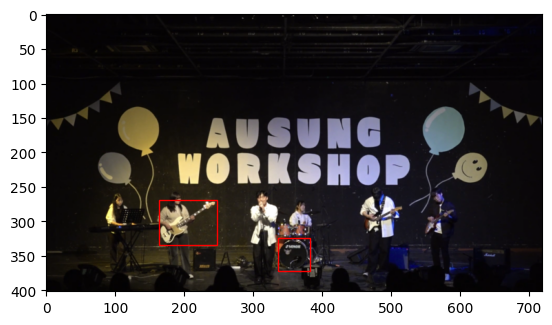

In [5]:
image = Image.open("image/band.png")
image = image.convert("RGB")

results = model(image)
model.visualize(image,results)